Figuring out how to output roundness/sharpness, and looking into
what happens when using two different aperture sizes.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry,CircularAnnulus,CircularAperture
from photutils import DAOStarFinder

In [2]:
# image = 'hor1DRCs/jdan20010_drc.fits'
# hdu = fits.open(image)
# sci = hdu[1].data
# hdr = hdu[0].header
# tab = hdu[4].data
# photflam = hdu[1].header['PHOTFLAM']

# data = hdu[1].data
# hdu.close()

# temp_sci=data*hdr['texptime']

# fits.writeto('hor1DRCs/F814W_ctsALL_raw.fits', temp_sci, header=hdr)

In [3]:
image = 'hor1DRCs/F814W_ctsALL_raw.fits'
# fits.info(image)

hdu = fits.open(image)
sci = hdu[0].data
hdr = hdu[0].header
hdu.close()

In [4]:
data = sci.copy()

In [5]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
print(mean, median, std)

0.49618652 -0.06826966 19.541706


In [6]:
daofind = DAOStarFinder(fwhm=2., threshold=3.*std)
sources = daofind(data - median)
print(len(sources))

43394


In [7]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures_r3 = CircularAperture(positions, r=3.)

rawflux_r3 = aperture_photometry(data, apertures_r3)

In [8]:
rawflux_r3['roundness1']= sources['roundness1']
rawflux_r3['roundness2']= sources['roundness2']
rawflux_r3['sharpness']= sources['sharpness']

In [9]:
annulus_apertures = CircularAnnulus(positions, r_in=9., r_out=12.)

annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)

In [10]:
rawflux_r3['annulus_median'] = bkg_median
rawflux_r3['aper_bkg'] = bkg_median*apertures_r3.area
rawflux_r3['final_phot'] = rawflux_r3['aperture_sum'] - rawflux_r3['aper_bkg']

In [11]:
apertures_r5 = CircularAperture(positions, r=5.)
rawflux_r5 = aperture_photometry(data, apertures_r5)

rawflux_r5['aper_bkg'] = rawflux_r3['annulus_median']*apertures_r5.area
rawflux_r5['final_phot'] = rawflux_r5['aperture_sum'] - rawflux_r5['aper_bkg']

In [12]:
mask_negative = (rawflux_r3['final_phot'] > 0) & (rawflux_r5['final_phot'] > 0)

rawflux_pos_r3 = rawflux_r3[mask_negative]
rawflux_pos_r5 = rawflux_r5[mask_negative]

mag_r3 = -2.5*np.log10(rawflux_pos_r3['final_phot'])
mag_r5 = -2.5*np.log10(rawflux_pos_r5['final_phot'])

deltamag = mag_r3 - mag_r5

/Users/hr8jz/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


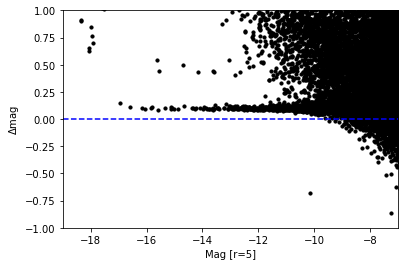

In [14]:
plt.figure()
plt.scatter(mag_r5, deltamag, c='k', s=10)
plt.axhline(ls='--', c='b')
plt.xlim(-19,-7)
plt.ylim(-1,1)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

plt.show()

0.1007428296735231


Text(0, 0.5, '$\\Delta$mag')

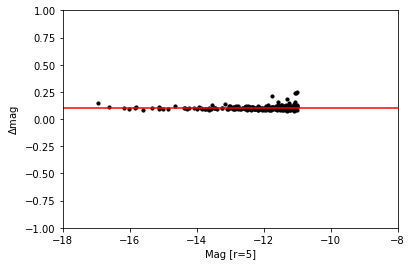

In [15]:
mask = (mag_r5 > -17.) & (mag_r5 < -11.) & (deltamag > 0.) & (deltamag < 0.25)

mean, median, std = sigma_clipped_stats(deltamag[mask], sigma=3.0, maxiters=5)
apcor = median
print(apcor)

plt.figure()
plt.scatter(mag_r5[mask], deltamag[mask], c='k', s=10)
plt.axhline(apcor,ls='-',c='r')
plt.xlim(-18,-8)
plt.ylim(-1,1)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

In [17]:
image = 'hor1DRCs/jdan20010_drc.fits'

# fits.info(image)

hdu = fits.open(image)
hdr = hdu[0].header
photflam = hdu[1].header['PHOTFLAM']

hdu.close()

In [18]:
other = -2.5*np.log10(photflam/hdr['texptime']/0.770)
print(other)

56.646809561804936


In [19]:
ap_cor = -2.5 * np.log10(0.770)
print(ap_cor)

0.2837731870687953


In [20]:
zpt = 26.779

In [21]:
final_phot = -2.5*np.log10(rawflux_pos_r3['final_phot']) - apcor + zpt
print(final_phot[:20])

    final_phot    
------------------
20.738451180983084
19.466387748983408
 20.38982301470881
18.523372872104353
  19.4421514278229
 19.55068078824288
 20.04691594694212
 21.57197189725277
16.739418491576565
18.515682760359578
 21.19542193922324
 19.91027496488907
21.752746276260662
16.876852896346378
20.931771494831573
 18.56018346351079
 20.41094517689998
21.330885514027898
18.837817920010313
 19.64415221273873


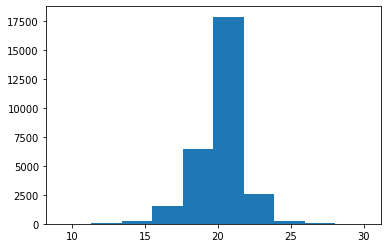

In [22]:
plt.hist(final_phot)
plt.show()